In [1]:


from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [27]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

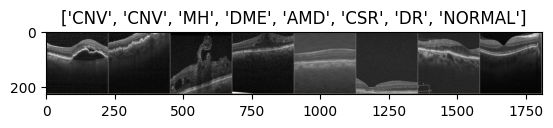

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 8)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss().to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

D:\PycharmProjects\TER\TER\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\PycharmProjects\TER\TER\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.4866 Acc: 0.8177
val Loss: 0.1221 Acc: 0.9586

Epoch 1/4
----------
train Loss: 0.3498 Acc: 0.8639
val Loss: 0.1009 Acc: 0.9639

Epoch 2/4
----------
train Loss: 0.3045 Acc: 0.8855
val Loss: 0.1171 Acc: 0.9646

Epoch 3/4
----------
train Loss: 0.2787 Acc: 0.8905
val Loss: 0.0941 Acc: 0.9714

Epoch 4/4
----------
train Loss: 0.2605 Acc: 0.9029
val Loss: 0.1313 Acc: 0.9539

Training complete in 20m 12s
Best val Acc: 0.971429


In [17]:
#save model
torch.save(model_ft.state_dict(), 'model_ft.pth')

tensor([5, 4, 3, 7, 1, 0, 3, 1])


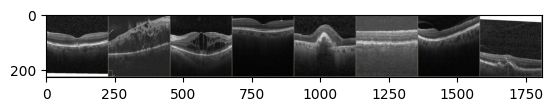

GroundTruth:  DRUSEN    DR   DME NORMAL   CNV   AMD   DME   CNV


In [20]:
# Get a random subset of the images
inputs, classes = next(iter(dataloaders['val']))
print(classes)
#display images
imshow(torchvision.utils.make_grid(inputs))
print('GroundTruth: ', ' '.join('%5s' % class_names[classes[j]] for j in range(8)))


In [21]:
#display predictions
outputs = model_ft(inputs.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(8)))

Predicted:  DRUSEN    DR   DME NORMAL   CNV   AMD NORMAL   CNV


In [22]:
model_ft.eval()

correct = 0
total = 0

with torch.no_grad():
    for data in dataloaders['val']:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on tval images: %d %%' % (100 * correct / total))

Accuracy of the network on tval images: 97 %


In [25]:
model_ft.eval()


# Initialize a dictionary to store the accuracies for each label
accuracies = {}
# Loop over the val set
for inputs , labels in dataloaders['val']:
    # Move the inputs and labels to the device
    inputs = inputs.to(device)
    labels = labels.to(device)
    # Get the predictions
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    # Loop over the predictions and labels
    for pred, label in zip(preds, labels):
        # If the label is not in the dictionary, add it
        if label.item() not in accuracies:
            accuracies[label.item()] = []
        # Append the prediction to the list of predictions for that label
        accuracies[label.item()].append(pred.item() == label.item())

In [26]:
# Loop over the accuracies
for label, acc in accuracies.items():
    # Calculate the accuracy for each label
    accuracies[label] = sum(acc) / len(acc)
    # Print the accuracy
    print(f'Accuracy for label {class_names[label]}: {accuracies[label]}')

Accuracy for label NORMAL: 0.98
Accuracy for label CSR: 1.0
Accuracy for label MH: 1.0
Accuracy for label CNV: 0.9257142857142857
Accuracy for label DRUSEN: 0.9171428571428571
Accuracy for label AMD: 1.0
Accuracy for label DME: 0.9485714285714286
Accuracy for label DR: 1.0
